In [1]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

import multiDrafts as md

In [2]:
def one_learner(
    num_learners = 1,
    collection_eps = 1,
    gamma=0.25,
    epsilon=.5,
    alpha=.001,
    df_bound=-1,
    frac=1,
):

    qtabs = []
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df('ensemble_testing.pkl')
    dh.df = dh.df[:df_bound]

    # Make new learner list based on newest data
    learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                            gamma=gamma, epsilon=epsilon, alpha=alpha)  
    return learners[0],dh

def multiproc_sampled_models(
    num_learners = 10,
    collection_eps = 20,
    gamma=.25,
    epsilon=.5,
    alpha=.001,
    df_bound=-1,
    learn_limit=50000,
    frac=.5,
    init_df = 'ensemble_testing.pkl',
):
    '''
    Runs parallel learners and joins them afterward
    '''
    qtabs = []
    worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    dh.df = dh.df[:df_bound]
    
    for loop in range(collection_eps):        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                                gamma=gamma, epsilon=epsilon, alpha=alpha, 
                                q_checkpoint=worm_agent.Qtab,
                                )        
        
        # Start multiprocessing
        #manager = multiprocessing.Manager()
        #poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print(f'{loop}',end='\r')
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'learn_limit':learn_limit}))
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        qtabs.append(worm_agent.Qtab.reshape((12,12,2)))
    return qtabs

def eval_ep(lea,eval_steps=200000):
    obss = []
    acts = []
    rews = []
    for i in range(eval_steps):
        obs = lea.env._state
        acts.append(lea.agent.eval_act(obs))
        next_obs,rew,done,_ = lea.env.step(acts[-1])
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

def plot_pol_and_qs(lea,vmin=-1,vmax=1):
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches((12,2))
    img = ax[0].imshow(np.sign(lea.agent.Qtab[:,1].reshape(12,12)-lea.agent.Qtab[:,0].reshape(12,12)))
    fig.colorbar(img,ax=ax[0]);
    ax[0].set_title('Current policy')
    img = ax[1].imshow(lea.agent.Qtab[:,1].reshape(12,12),vmin=vmin,vmax=vmax)
    fig.colorbar(img,ax=ax[1]);
    ax[1].set_title('Light on Qtable')
    img = ax[2].imshow(lea.agent.Qtab[:,0].reshape(12,12),vmin=vmin,vmax=vmax)
    plt.colorbar(img,ax=ax[2])
    ax[2].set_title('Light off Qtable')

    [ax[i].axis('off') for i in range(3)];
    
def learn_ep(lea,l_steps=1000000,ep_len=100):
    obss = []
    acts = []
    rews = []
    for i in range(l_steps):
        if i%ep_len==0:
            lea.env.reset()
        obs = lea.env._state
        acts.append(lea.agent.act(obs))
        next_obs,rew,done,_ = lea.env.step(acts[-1])
        lea.agent.update(obs,acts[-1],next_obs,rew)
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

# 0. Baselines for one model; make sure everything works

### With frac=.5 

In [3]:
learner,dh = one_learner(frac=.5)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)

On model 0
Penalty 0.6632711783135059


#### Eval ep, random actions

In [4]:
obss,acts,rews = eval_ep(learner)
print(f'From init, eval episode reward is {np.mean(rews)}')

From init, eval episode reward is 0.23279650575269217


#### Eval ep, actions from reward mat

In [5]:
learner.agent.Qtab[:,0] = np.zeros(144)
learner.agent.Qtab[:,1] = np.sign(learner.modset.models[0]['reward_on'][:,:,0]-learner.modset.models[0]['reward_off'][:,:,0]).flatten()
obss,acts,rews = eval_ep(learner)

Just given reward matrices, no learning, eval ep is 0.493115744684715


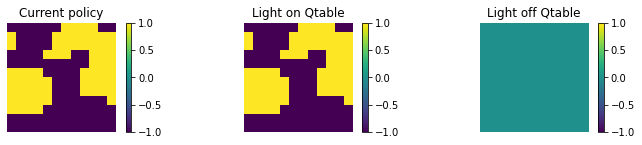

In [6]:
plot_pol_and_qs(learner)
print(f'Just given reward matrices, no learning, eval ep is {np.mean(rews)}')

#### Learning eps

Eval ep is 0.2394102670034026


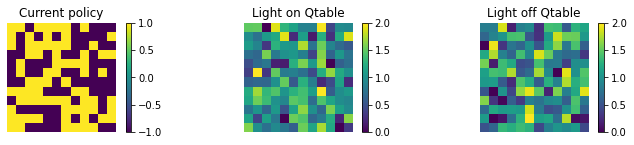

In [7]:
learner.agent.resetq()
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=0,vmax=2)
print(f'Eval ep is {np.mean(rews)}')

1m learning steps, eval ep is 0.46115855863549476


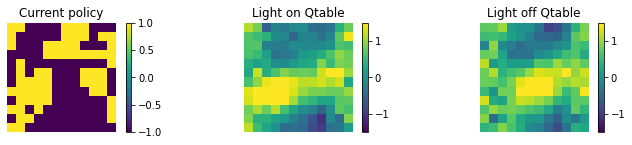

In [8]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'1m learning steps, eval ep is {np.mean(rews)}')

2m learning steps, eval ep is 0.4773322436953505


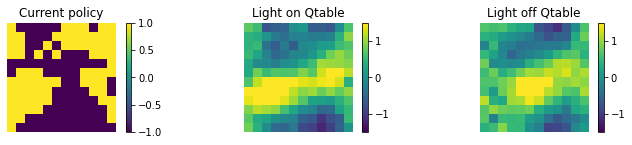

In [9]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'2m learning steps, eval ep is {np.mean(rews)}')

3m learning steps, eval ep is 0.5037681856193543


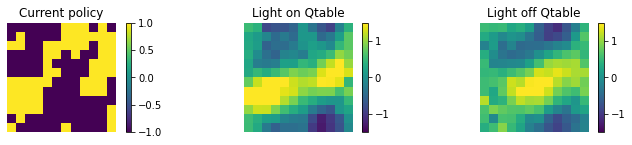

In [10]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'3m learning steps, eval ep is {np.mean(rews)}')

### With frac=1

In [11]:
learner,dh = one_learner(frac=1)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)

On model 0
Penalty 0.6387606454371175


#### Eval ep, random actions

In [12]:
obss,acts,rews = eval_ep(learner)
print(f'From init, eval episode reward is {np.mean(rews)}')

From init, eval episode reward is 0.30966701788358786


#### Eval ep, actions from reward mat

In [13]:
learner.agent.Qtab[:,0] = np.zeros(144)
learner.agent.Qtab[:,1] = np.sign(learner.modset.models[0]['reward_on'][:,:,0]-learner.modset.models[0]['reward_off'][:,:,0]).flatten()
obss,acts,rews = eval_ep(learner)

Just given reward matrices, no learning, eval ep is 0.4837078230992999


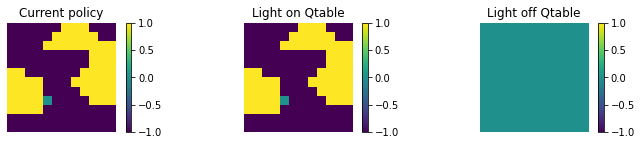

In [14]:
plot_pol_and_qs(learner)
print(f'Just given reward matrices, no learning, eval ep is {np.mean(rews)}')

#### Learning eps

Eval ep is 0.2898095425088867


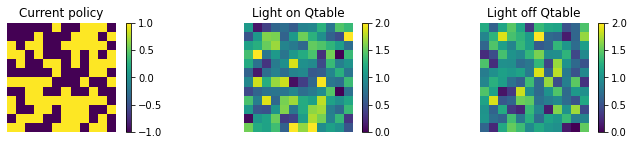

In [15]:
learner.agent.resetq()
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=0,vmax=2)
print(f'Eval ep is {np.mean(rews)}')

1m learning steps, eval ep is 0.4665499993438702


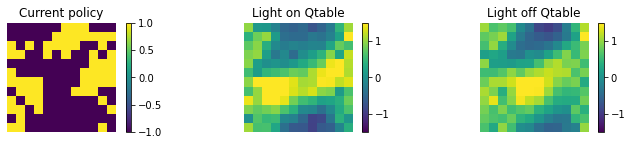

In [16]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'1m learning steps, eval ep is {np.mean(rews)}')

2m learning steps, eval ep is 0.47235856762473866


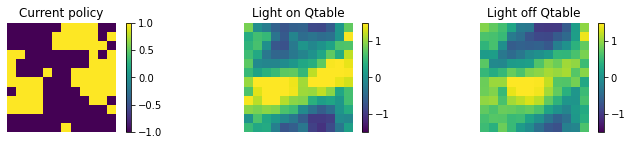

In [17]:
obss,acts,rews = learn_ep(learner)
obss,acts,rews = eval_ep(learner)
plot_pol_and_qs(learner,vmin=-1.5,vmax=1.5)
print(f'2m learning steps, eval ep is {np.mean(rews)}')

# 1. All data with partial models vs full models, averaged

In [18]:
qtabs = []
fracs = [.5,1]
for f in fracs:
    for i in range(5):
        qtabs.append(multiproc_sampled_models(
        num_learners = 10,
        collection_eps = 20,
        gamma=.25,
        epsilon=.5,
        alpha=.001,
        df_bound=-1,
        learn_limit=50000,
        frac=f, # Only variable that was changed between 1a and 1b
    ))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [19]:
scores = []
learner,dh = one_learner(frac=1)
learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)
for qtset in qtabs:
    for i,qt in enumerate(qtset):
        print(i)
        learner.agent.Qtab = qt.reshape((144,2))
        obss,acts,rews = eval_ep(learner)
        scores.append(np.mean(rews))

On model 0
Penalty 0.6387606454371175
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Plots for everything

In [20]:
scores_list = [[] for _ in range(10)]
for i in range(10):
    scores_list[i] = scores[i*20:i*20+20]
partials = np.mean(scores_list[:5],axis=0)
fulls = np.mean(scores_list[5:],axis=0)
partials_s = np.std(scores_list[:5],axis=0)
fulls_s = np.std(scores_list[5:],axis=0)

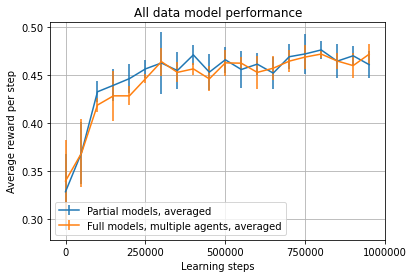

In [21]:
plt.errorbar(np.arange(20),partials,yerr=partials_s)
plt.errorbar(np.arange(20),fulls,yerr=fulls_s)
plt.ylabel('Average reward per step')
plt.xlabel('Learning steps')
plt.xticks(np.arange(0,21,5),np.arange(0,21,5)*50000);
plt.title('All data model performance')
plt.legend(['Partial models, averaged','Full models, multiple agents, averaged'])
plt.grid();

# 2. Partial data

## a. First, try reward-only.

In [7]:
f = 1
samps_df = [5000,10000,15000,20000,25000,30000]

# First get reward matrix-based performance.
all_no_learn = []
all_no_learn_pol = []

for s in samps_df:
    perf,q_diffs = md.no_learn_performance(s,f)
    all_no_learn.append(perf)
    all_no_learn_pol.append(q_diffs)

On model 0
Penalty 1.3361008439277549
On model 0
Penalty 0.6387606454371175
On model 0
Penalty 0.7910633691056539
On model 0
Penalty 0.6387606454371175
On model 0
Penalty 0.7841632852884368
On model 0
Penalty 0.6387606454371175
On model 0
Penalty 0.654260860303365
On model 0
Penalty 0.6387606454371175
On model 0
Penalty 0.49982802958365824
On model 0
Penalty 0.6387606454371175
On model 0
Penalty 0.4974787738116292
On model 0
Penalty 0.6387606454371177


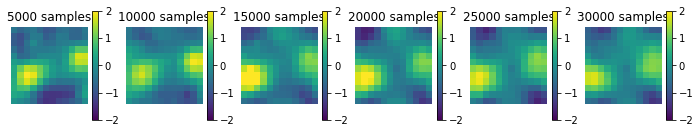

In [9]:
fig,ax = plt.subplots(1,6)
fig.set_size_inches((12,2))
for i,samp in enumerate(samps_df):
    img = ax[i].imshow(all_no_learn_pol[i],vmin=-2,vmax=2)
    fig.colorbar(img,ax=ax[i])
    ax[i].set_title(f'{samp} samples')
    ax[i].axis('off')

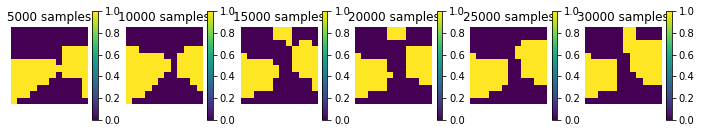

In [10]:
fig,ax = plt.subplots(1,6)
fig.set_size_inches((12,2))
for i,samp in enumerate(samps_df):
    img = ax[i].imshow(np.sign(all_no_learn_pol[i]),vmin=0,vmax=1)
    fig.colorbar(img,ax=ax[i])
    ax[i].set_title(f'{samp} samples')
    ax[i].axis('off')

In [11]:
f = .5
samps_df = [5000,10000,15000,20000,25000,30000]
trials = 10

half_no_learn = []
half_no_learn_pol = []
# Run main functions: train agents and collect more data
for i,s in enumerate(samps_df):
    pool = multiprocessing.Pool()
    lea_outs = []
    for _ in range(trials):
        lea_outs.append(pool.apply_async(md.no_learn_performance, [s,f]))
    # Wait for them to finish
    pool.close()
    pool.join()
    for lea_out in lea_outs:
        if lea_out.successful() is False:
            raise Exception('One learner failed')

    for ii,lea_out in enumerate(lea_outs):
        perf,q_diffs = lea_out.get()
        if ii==0:
            half_no_learn.append(perf/trials)
            half_no_learn_pol.append(q_diffs/trials)
        else:
            half_no_learn[i] += perf/trials
            half_no_learn_pol[i] += q_diffs/trials

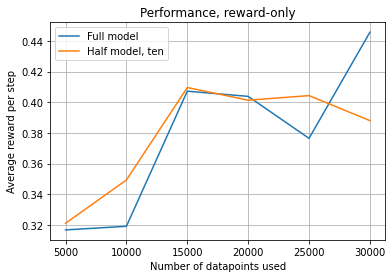

In [12]:
plt.plot(all_no_learn,label='Full model')
plt.plot(half_no_learn,label='Half model, ten')
plt.title('Performance, reward-only')
plt.xticks(range(6),np.arange(5000,30001,5000))
plt.ylabel('Average reward per step')
plt.xlabel('Number of datapoints used');
plt.legend();

plt.grid();

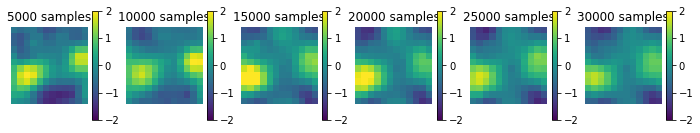

In [13]:
fig,ax = plt.subplots(1,6)
fig.set_size_inches((12,2))
for i,samp in enumerate(samps_df):
    img = ax[i].imshow(half_no_learn_pol[i],vmin=-2,vmax=2)
    fig.colorbar(img,ax=ax[i])
    ax[i].set_title(f'{samp} samples')
    ax[i].axis('off')

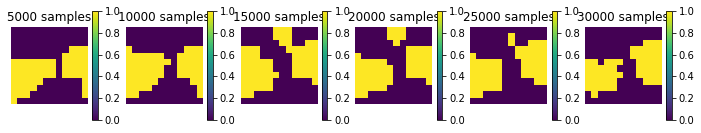

In [14]:
fig,ax = plt.subplots(1,6)
fig.set_size_inches((12,2))
for i,samp in enumerate(samps_df):
    img = ax[i].imshow(np.sign(half_no_learn_pol[i]),vmin=0,vmax=1)
    fig.colorbar(img,ax=ax[i])
    ax[i].set_title(f'{samp} samples')
    ax[i].axis('off')

## b. With learning

In [3]:
def compare_ensembles(df_bound,trials=5,learn_limit=25000,collection_eps=20):
    # Returns average rewards over five random seeds for 1. full dataset 2. random sampling of dataset,
    # each with ten learners that are then averaged. 
    
    # First train all models 
    qtabs = []
    fracs = [.5,1]
    for f in fracs:
        print(f'On {f}')
        for i in range(trials):
            print(f'\tTrial {i}')
            qtabs.append(multiproc_sampled_models(
            num_learners = 10,
            collection_eps = collection_eps,
            gamma=.25,
            epsilon=.5,
            alpha=.001,
            df_bound=df_bound,
            learn_limit=learn_limit,
            frac=f, 
        ))
            
    # Score them on full df
    scores = []
    learner,dh = one_learner(frac=1)
    learner.make_mod_and_env(dh,{'lambda':.1,'iters':10},)
    for ii,qtset in enumerate(qtabs):
        for i,qt in enumerate(qtset):
            print(f'Scoring {i} for tab {ii}\t\t',end='\r')
            learner.agent.Qtab = qt.reshape((144,2))
            obss,acts,rews = eval_ep(learner)
            scores.append(np.mean(rews))

    # Separating the scores
    scores_list = [scores[i*collection_eps:i*collection_eps+collection_eps] for i in range(2*trials)]
    partials = np.mean(scores_list[:trials],axis=0)
    fulls = np.mean(scores_list[trials:],axis=0)
    partials_s = np.std(scores_list[:trials],axis=0)
    fulls_s = np.std(scores_list[trials:],axis=0)
    
    return partials,partials_s,fulls,fulls_s

In [4]:
samps_df = [5000,10000,15000,20000,25000,30000]
half, full, half_s, full_s = [],[],[],[]
for s in samps_df:
    p,ps,f,fs = compare_ensembles(s,learn_limit=25000,collection_eps=20,trials=5)
    half.append(p)
    half_s.append(ps)
    full.append(f)
    full_s.append(fs)

On 0.5
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371175
On 0.5g 19 for tab 9		
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371175
On 0.5g 19 for tab 9		
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371175
On 0.5g 19 for tab 9		
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371175
On 0.5g 19 for tab 9		
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371177
On 0.5g 19 for tab 9		
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On 1
	Trial 0
	Trial 1
	Trial 2
	Trial 3
	Trial 4
On model 0
Penalty 0.6387606454371175


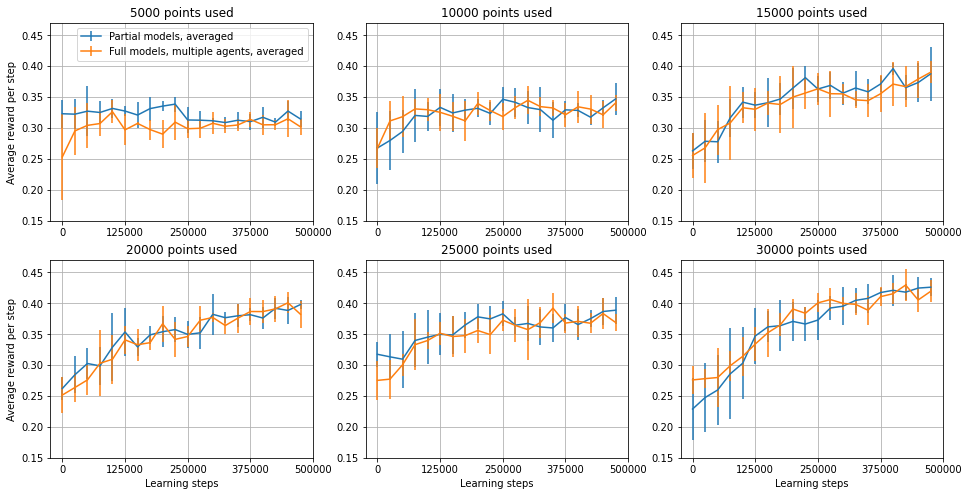

In [12]:
fig,ax = plt.subplots(2,3)
fig.set_size_inches((16,8))
for i in range(len(half)):
    cax = ax[i//3,i%3]
    cax.errorbar(np.arange(len(half[i])),half[i],yerr=half_s[i])
    cax.errorbar(np.arange(len(full[i])),full[i],yerr=full_s[i])
    cax.set_xticks(np.arange(0,21,5))
    cax.set_xticklabels(np.arange(0,21,5)*25000)
    cax.set_ylim([.15,.47])
    cax.set_title(f'{samps_df[i]} points used')
    cax.grid();

ax[0,0].legend(['Partial models, averaged','Full models, multiple agents, averaged'])
[ax[i,0].set_ylabel('Average reward per step') for i in range(2)]
[ax[-1,i].set_xlabel('Learning steps') for i in range(3)];